# Extract geometric features and train a FEA model

This notebook has 2 sections. In the first section, the training and validation features are estimated. In the second section, an analysis is conducted, in order to estimate the most appropriate regularization factor (number of components). At the end, a final Partial Least Squares (PLS) model is trained, based on the optimal regularization factor.

## Extraction of facial geometric features

First we load the training and validation datasets. These datasets are CSV files containing the extracted 68 DLIB facial landmarks, as well as automatic annotations for Arousal, Valence and Intensity of expression, from thousands of morphed faces. These facial morphings follow Russell's Circumplex Model of Affect, and automatically provide annotations for the 3 dimensions of emotion. You can find more details on how to generate this synthetic dataset, [in this paper](https://arxiv.org/abs/2103.02854). 

Then we calculate the facial geometric features from each set of 68 facial landmarks. As features, we define the normalized Eucledian distances between all the possible landmark pairs, across all the facial landmarks of a training face. A detailed description of this process can be found in [this paper](https://arxiv.org/abs/2106.07817). If all facial landmarks are considered, then the "68 choose 2" result in 2278 combinations of distances. If we exclude the 17 landmarks of the jaw line (which the don't really contribute to facial expressions) then the "51 choose 2" combinations result to 1276 distances, which is considerably lower dimensionality. Here we choose this option. However, you can easily set `FULL_FEATURES = True` and the full 2278 set of features will be computed.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
from emotions_dlib import GeometricFeaturesDlib, LandmarkFrontalizationDlib

In [2]:
# if FULL_FEATURES=False (exclude jawline) resulting dimensionality -> 1276
# if FULL_FEATURES=True (all 68 landmarks) resulting dimensionality -> 2278
FULL_FEATURES = False
PATH_DATA = '../data/'
PATH_MODELS = '../models/'

geom_feat = GeometricFeaturesDlib(full_size=FULL_FEATURES)    
frontalizer = LandmarkFrontalizationDlib(
    file_frontalization_model=f'{PATH_MODELS}model_frontalization.npy'
    )

Feature template size: (1275, 2)
Frontalization weights loaded successfully.


In [8]:
# load dataset
try:
    df_data = pd.read_csv(f'{PATH_DATA}Morphset.csv')
except:
    !unzip ../data/Morphset.csv.zip -d ../data/
    df_data = pd.read_csv(f'{PATH_DATA}Morphset.csv')

df_data.head(10)


Archive:  ../data/Morphset.csv.zip
  inflating: ../data/Morphset.csv    
  inflating: ../data/__MACOSX/._Morphset.csv  


,Filename,Dataset,Subject,Emotion Label,Agreement,Arousal,Valence,Intensity,x0,x1,...,y58,y59,y60,y61,y62,y63,y64,y65,y66,y67
0,R_1_NE_1.jpg,R,1.0,NE,0.710,0.000000,0.000000,0.000000,10.0,14.0,...,350.0,346.0,335.0,326.0,326.0,325.0,333.0,327.0,328.0,328.0
1,R_1_NE_2.jpg,R,1.0,NE,0.710,0.000000,0.000000,0.000000,16.0,21.0,...,349.0,344.0,334.0,325.0,326.0,326.0,336.0,328.0,328.0,327.0
2,R_1_HA_1_1.jpg,R,1.0,HA,0.735,0.014317,0.081196,0.082449,10.0,14.0,...,352.0,346.0,333.0,326.0,327.0,326.0,332.0,328.0,330.0,329.0
3,R_1_HA_1_2.jpg,R,1.0,HA,0.735,0.014317,0.081196,0.082449,17.0,21.0,...,350.0,344.0,333.0,325.0,326.0,326.0,335.0,329.0,330.0,328.0
4,R_1_HA_2_1.jpg,R,1.0,HA,0.760,0.028634,0.162393,0.164898,10.0,13.0,...,354.0,346.0,332.0,328.0,328.0,327.0,330.0,329.0,331.0,330.0
5,R_1_HA_2_2.jpg,R,1.0,HA,0.760,0.028634,0.162393,0.164898,16.0,20.0,...,352.0,344.0,331.0,327.0,328.0,327.0,332.0,330.0,331.0,329.0
6,R_1_HA_3_1.jpg,R,1.0,HA,0.785,0.042951,0.243589,0.247347,9.0,12.0,...,354.0,345.0,330.0,328.0,328.0,327.0,329.0,330.0,332.0,331.0
7,R_1_HA_3_2.jpg,R,1.0,HA,0.785,0.042951,0.243589,0.247347,16.0,20.0,...,353.0,344.0,329.0,326.0,327.0,326.0,331.0,332.0,333.0,331.0
8,R_1_HA_4_1.jpg,R,1.0,HA,0.810,0.057268,0.324786,0.329796,11.0,14.0,...,355.0,345.0,328.0,323.0,323.0,322.0,327.0,332.0,334.0,333.0
9,R_1_HA_4_2.jpg,R,1.0,HA,0.810,0.057268,0.324786,0.329796,18.0,20.0,...,354.0,344.0,326.0,322.0,323.0,323.0,329.0,334.0,335.0,333.0


In [4]:
df_data.describe()

,Subject,Agreement,Arousal,Valence,Intensity,x0,x1,x2,x3,x4,...,y58,y59,y60,y61,y62,y63,y64,y65,y66,y67
count,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,...,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000,166382.000000
mean,318.406763,0.835600,0.216831,-0.152848,0.485324,10.829723,13.808777,20.302593,27.875365,40.598749,...,370.783841,363.306638,346.522226,341.193308,342.530172,341.023248,346.659573,348.558396,350.388696,348.598238
std,201.214189,0.110886,0.272481,0.402004,0.265878,8.290022,8.387100,9.041308,9.596424,9.380216,...,14.057757,12.170877,10.497785,10.235104,10.298511,10.152569,10.584181,12.339205,12.584049,12.410791
min,1.000000,0.050000,-0.422618,-0.996195,0.000000,-18.000000,-14.000000,-10.000000,-4.000000,3.000000,...,247.000000,243.000000,240.000000,240.000000,242.000000,243.000000,248.000000,243.000000,241.000000,238.000000
25%,148.000000,0.784960,0.040400,-0.431229,0.257708,5.000000,8.000000,15.000000,22.000000,35.000000,...,361.000000,355.000000,340.000000,334.000000,336.000000,334.000000,340.000000,340.000000,342.000000,340.000000
50%,296.000000,0.858750,0.162026,-0.156283,0.492296,11.000000,14.000000,21.000000,29.000000,41.000000,...,370.000000,363.000000,346.000000,341.000000,342.000000,341.000000,346.000000,347.000000,349.000000,347.000000
75%,484.000000,0.912000,0.393923,0.068571,0.700000,17.000000,20.000000,27.000000,35.000000,47.000000,...,380.000000,371.000000,353.000000,347.000000,349.000000,347.000000,353.000000,356.000000,358.000000,356.000000
max,712.000000,1.000000,0.991060,0.984808,1.000000,46.000000,46.000000,55.000000,66.000000,79.000000,...,447.000000,432.000000,395.000000,389.000000,391.000000,389.000000,397.000000,423.000000,425.000000,423.000000


In [5]:
# calculate features
ls_features = []
for i in range(len(df_data)):
    clear_output(wait=True)
    display('Processing face ' + str(i) + 
          ' out of ' + str(len(df_data)) + 
          ' [' + str(round((i*100)/len(df_data),3)) + '%]'
          )
    landmarks_raw = df_data.iloc[i,8:].values  # get landmarls (136,1)
    landmarks_raw = np.reshape(landmarks_raw, (2,68)).T  # transform to (68,2)
    dict_landmarks = frontalizer.frontalize_landmarks(
        landmarks_object=landmarks_raw
        )
    landmarks_frontal = dict_landmarks['landmarks_frontal']
    features = geom_feat.get_features(landmarks_frontal).astype(np.float16)
    ls_features.append(features)
         
# save features (for future reuse)    
features = np.array(ls_features, dtype=np.float16)
np.save(
        f'{PATH_DATA}features_fullfeatures={FULL_FEATURES}.npy', 
        features, 
        allow_pickle=True, 
        fix_imports=True
        )

'Processing face 166381 out of 166382 [99.999%]'

## Subject-based dataset splitting

In the Morphset dataset we have multiple rows (facial expressions) per subject (people who posed for the expression), and 712 subjects in total. As such, a typical expression-based dataset splitting, where we randomize and split the dataset per row (i.e. per expressions), would not be a good idea. This is because, different variations of the same expression from the same person could both appear in the train/validation/test splits. For example, a slightly happy face of person A could end up in the training split, a moderately happy face of person A could end in the validation split, and a happy face of person A could end up in the testing split, meaning, images of person A would end up in all 3 splits. This can increase the chance of overfitting, because, the model may learn the *identity* of the person (the individual characteristics of someone's face), rather the facial expressions. 

We want our facial expression analysis model to learn expressions and not individual identities. Consequently, a better approach is to have a subject-based splitting, where the dataset is partitioned based on subject IDs, rather than subject expressions. So, all training examples (facial expressions) of person A, can either be in the training, validation or testing splits, but not in more than one of them at the same time. This approach ensures that a better "insulation" to overfitting.

In [6]:
np.random.seed(1)
max_subjects = int(df_data['Subject'].values.max())
subjets = np.array(range(1,max_subjects))
np.random.shuffle(subjets)

# 70% train, 20% validation, 10% testing subjects
subjects_train, subjects_val, subjects_test = np.split(subjets, [int(.7*len(subjets)), int(.9*len(subjets))])

# subjects to indices
indx_train = list(df_data['Subject'].isin(subjects_train))
indx_val = list(df_data['Subject'].isin(subjects_val))
indx_test = list(df_data['Subject'].isin(subjects_test))

In [7]:
# split features
features_train = features[indx_train, :]
features_val = features[indx_val, :]
features_test = features[indx_test, :]

# split annotations
avi_train = df_data.iloc[indx_train,5:8].values.astype(np.float16)
avi_val = df_data.iloc[indx_val,5:8].values.astype(np.float16)
avi_test = df_data.iloc[indx_test,5:8].values.astype(np.float16)


The main columns that are of interest to us are the automatic emotion annotations (Arousal, Valence, Intensity) and the facial landmark coordinates (x0, x1, ... y66, y67). We will now calculate the validation and training features, from the landmark coordinates. This may take some time to run, since, for the training set there are 153692 different morphed faces.


## Training a Partial Least Squares (PLS) model

We will now train a PLS regression model, in order to estimate the Arousal, Valence and Intensity dimensions of facial expressions. One important hyperparameter of PLS models, is the number of components. This acts as a regularization parameter. Lower number of components result to more regularized models (may underfit the data), and higher number of components result to less regularized models (may overfit the data). We train 50 different PLS models with 1-50 components, and estimate their performance. We will choose the one that achieves a balance between regularization and lower mean square error (or canonical correlation coefficient). 

In [8]:
def get_mse(y_gt,y_predict):
    # Compute mean square error
    MSE = np.mean((y_gt - y_predict)**2, axis=0)
#    return np.sqrt(MSE).tolist()
    return MSE.tolist()

def get_ccc(y_gt,y_predict):
    # Compute canonical correlation coefficient
    CCC=[]
    for i in range(y_gt.shape[1]):
        A=y_gt[:,i]
        B=y_predict[:,i]
        pearson = pearsonr(A, B)
        c = (2 * pearson[0] * A.std() * B.std()) / ( A.std()**2 + B.std()**2 + (A.mean() - B.mean())**2 )
        CCC.append(c)
    return CCC

In [9]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
from joblib import dump

plt.close('all')
plt.style.use('seaborn')

Here we train 50 PLS models from 1 to 50 components. The higher number of components, the more time a model needs for training. This may take some time to run (up to an hour!). If you are not patient, you can skip this part and go directly to the last cell, where you can select a PLS model by directly defining the number of components that you want. 

In [10]:
performance = []
i=0

for components in range(1,50,1):
    pls = PLSRegression(n_components=components)
    pls.fit(features_train, avi_train)
    y_predict = pls.predict(features_val)  # get validation results
    performance.append( [components, get_mse(avi_val, y_predict), get_ccc(avi_val, y_predict)] )  # store validation results
    print('Training PLS with ' + str(components) + ' components. MSE=' + str(performance[i][1]) + ' CCC=' + str(performance[i][2]))
    i=i+1

Training PLS with 1 components. MSE=[0.07061840332183093, 0.1287494478440748, 0.07050587183701094] CCC=[0.09972907256714471, 0.3444300473535042, 0.011911552426503652]
Training PLS with 2 components. MSE=[0.06830069107725863, 0.12755018727712347, 0.057781270058501824] CCC=[0.15517607411624046, 0.3515692067627705, 0.3207366448797759]
Training PLS with 3 components. MSE=[0.06830332827243192, 0.09091702488463546, 0.05773886370330153] CCC=[0.15526262624490736, 0.6036261281933858, 0.321222701755431]
Training PLS with 4 components. MSE=[0.0668283858433612, 0.08839512066213107, 0.05434085723213461] CCC=[0.19639065465787783, 0.6164621320455459, 0.3738477824225124]
Training PLS with 5 components. MSE=[0.06503272679395192, 0.08546429033933065, 0.05424752473437733] CCC=[0.23612921986286256, 0.6363081703231721, 0.3782260752305538]
Training PLS with 6 components. MSE=[0.06475269354854205, 0.07400235572045102, 0.05233325481342024] CCC=[0.24393445734642022, 0.7050821086798077, 0.4085322408530786]
Trai

Let plot the results in order to understand which number of components achieves the best balance of regularization and performance. Generally, we are looking for some type of *elbow point*. We expect that MSE will go down fast, as the number of components and the model complexity increases. However, at some point, this reduction in MSE will stall or will be very slow. This is the point that we are looking for, as optiomal number of components. Beyond this point, MSE may be further reduced slightly, at the expense of a more complex model, which means higher chances for overfitting.

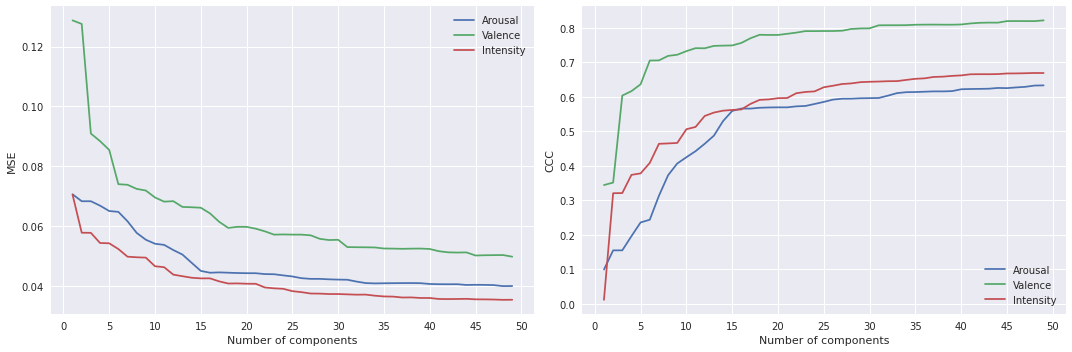

In [11]:
components = [performance[i][0] for i in range(len(performance))]
mse_arousal = [performance[i][1][0] for i in range(len(performance))]
mse_valence = [performance[i][1][1] for i in range(len(performance))]
mse_intensity = [performance[i][1][2] for i in range(len(performance))]
ccc_arousal = [performance[i][2][0] for i in range(len(performance))]
ccc_valence = [performance[i][2][1] for i in range(len(performance))]
ccc_intensity = [performance[i][2][2] for i in range(len(performance))]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.grid()
plt.plot(components, mse_arousal, label='Arousal')
plt.plot(components, mse_valence, label='Valence')
plt.plot(components, mse_intensity, label='Intensity')
plt.xticks(np.arange(0, 51, step=5))
plt.xlabel('Number of components')
plt.ylabel('MSE')
plt.tight_layout()
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.plot(components, ccc_arousal, label='Arousal')
plt.plot(components, ccc_valence, label='Valence')
plt.plot(components, ccc_intensity, label='Intensity')
plt.xticks(np.arange(0, 51, step=5))
plt.xlabel('Number of components')
plt.ylabel('CCC')
plt.tight_layout()
plt.grid()
plt.legend()

plt.show()

It looks like that (for `FULL_FEATURES = False`) a model with 31 components, strikes a good balance between performance and complexity. For `FULL_FEATURES = True` results may be different. Remember, number of components acts as regularization. Larger number of components (around 50) eventually exhibit better MSE and CCC, however, these models will be more complex and thus, will have higher chance of overfitting. Lets train a final model with 31 components and store it. This model will be later used for real-time inference.

In [12]:
FULL_FEATURES = False
COMPONENTS = 31

pls = PLSRegression(n_components=COMPONENTS)
pls.fit(features_train, avi_train)

y_predict = pls.predict(features_val)
MSE_val = get_mse(avi_val, y_predict)
print ('Validation MSE=',MSE_val)
ccc_val = get_ccc(avi_val, y_predict)
print('Validation CCC=',ccc_val)

y_predict = pls.predict(features_test)
MSE_test = get_mse(avi_test, y_predict)
print ('Test MSE=',MSE_test)
ccc_test = get_ccc(avi_test, y_predict)
print('Test CCC=',ccc_test)

output = {}
output['model'] = pls
output['full_features'] = FULL_FEATURES
output['components'] = COMPONENTS

dump(output, f'{PATH_MODELS}model_emotion_pls={COMPONENTS}_fullfeatures={FULL_FEATURES}.joblib')

Validation MSE= [0.04206255357232685, 0.05297562624615672, 0.03717766003051464]
Validation CCC= [0.5966802668593122, 0.8071984184716301, 0.6442543456951312]
Test MSE= [0.04152128343093004, 0.05187072321953769, 0.037158566313273536]
Test CCC= [0.5942706438488639, 0.8052973991255521, 0.6476388569870766]


['../models/model_emotion_pls=31_fullfeatures=False.joblib']